<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/1.1_strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
CONFIG_FILE='config.yaml'


#clone report for colab
import yaml,os,sys

#setup directories
if os.name=='nt':
    pass
else:               #colab setup below
    if not os.path.exists('./repo') :
        !git clone $repo repo
        sys.path.append("repo/lib")
        sys.path.append('repo')       
    !apt update
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    
sys.path.append('lib')
# sys.path.append(LIB)

import utils
cfg=utils.setup_env(CONFIG_FILE)  #auth_file defaulted from {AUTH}/auth/yaml

for x in cfg['env'][os.name]: 
    # os.environ[x]=cfg['env'][os.name][x]
    globals()[x]=cfg['env'][os.name][x]

#need to use following for each sheet
service_account_file=f'{os.environ["AUTH"]}/{cfg["AUTH"]["service_accounts"]["indiathon"]}'

## Code

In [2]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image, Markdown
import pandas as pd

import utils
import importlib
importlib.reload(utils)

import socialmediasite 
importlib.reload(socialmediasite)
Strava=socialmediasite.Strava
SocialMediaSite=socialmediasite.SocialMediaSite


In [3]:
"reach gsheet"

import gsheets
Gsheet=gsheets.Gsheet


# Process
## Create headless

In [4]:
" Test Selenium headless"

if True:
    import json
    env_var="BROWSER_SESSIONS"
    if os.name=='nt':
        b=Browser('chrome')
    else:

        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-09-22 15:32:33:INFO:Logger file: c:/m/logging/strava-automation.log


In [5]:

strava=Strava(b,                                                 #authFile=f'{AUTH}/auth.yaml',
              cfg=cfg,
              delay=.5)

df_mc=Gsheet(cfg['sheets']['stravasync']['url'],service_account_file=service_account_file
            ).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')
promoSheet=Gsheet(cfg['sheets']['StravaPromoLog']['url'],service_account_file=service_account_file)
strava.logGSheet = promoSheet.getSheetByTitle('StravaPromoLog') 
strava.promoCommentLog = promoSheet.getSheetByTitle('PromoCommentLog')
sessionGSheet = promoSheet.getSheetByTitle('SessionLog')

strava.promoCommentedIds=list(strava.promoCommentLog.get_as_df().id.values)
strava.StravaMembers=df_mc.query('strava=="strava"').id.values

%env COUNTER_PROMO_COMMENT 0

env: COUNTER_PROMO_COMMENT=0


# A. Mileage Certificates

In [6]:
strava.login("mileage_league_strava")

In [7]:
certSheet=Gsheet(cfg['sheets']['certs']['url'],service_account_file=service_account_file)
certTab=certSheet.getSheetByTitle(cfg['sheets']['certs']['tab'])
df_cert=certTab.get_as_df().query("comment_text!='' and Activity==''"
                                   ).reset_index()
cols={x:df_cert.columns.get_loc(x)+1 for x in ['comment_ts','comment_text']}
# display(cols)
# merge
_df=df_cert.merge(df_mc[['Email','profile','strava']],on='Email')

c:\sw\python37\lib\site-packages\pygsheets\worksheet.py:1477: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


In [8]:
_df['index 	CertType 	Email 	Milestone 	Name 	Date 	ID 	Team	comment_ts 	Activity 		profile 	strava'.split()]

,index,CertType,Email,Milestone,Name,Date,ID,Team,comment_ts,Activity,profile,strava
0,1373,WalkDist,umesh.divekar777@gmail.com,500,Umesh,9/20/2022,1H4nFtV4ptD4bYsiMuowoUMasXylDg9Ti,A,,,https://runkeeper.com/user/2459972584,runkeeper


In [9]:
if True:
    from pprint import pprint as pp

    for i,cert in _df.query("strava=='strava'").iterrows():
        # print (cert['index'],cert.profile,cert.comment_text)
        remark=''
        try:

            if not cert.profile: 
                logging.warning(f"{cert.Row},{cert.Name},{cert.profile} : {cert['index']} no profle")
                remark='No profile'
                continue
            b.goto(cert.profile)
            # url=f"https://www.strava.com/activities/{x['activity_id']}"
            if True:
                commentEl=b.button(data_testid="comment_button")
                strava.postComment(commentEl,cert.comment_text)
                logging.info(f"{cert.Row},{cert.Name},{cert.profile} :{cert.comment_text}")

                # break
        except Exception as e:
            logging.error(f"{cert.Row},{cert.Name},{cert.profile} : {e!r} ")
            # raise Exception("Something went wrong while posting comment")
            continue
        finally:
            certTab.update_values(crange=(cert.Row,cols['comment_ts']),
                             values=[[pd.Timestamp.now().isoformat(),cert.profile]])


# B. Give likes on Club

### avinash Feed Likes

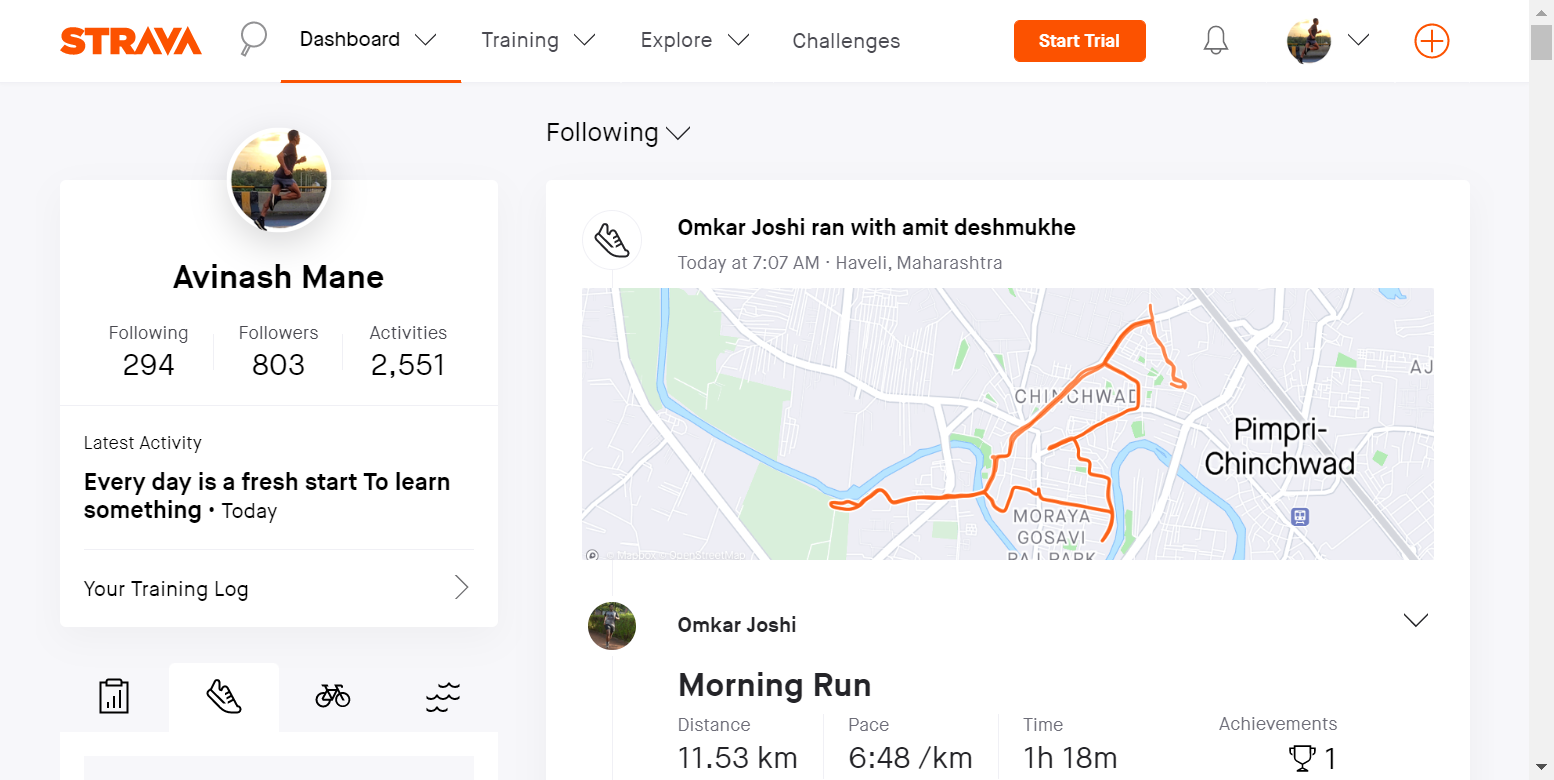

2022-09-22 15:33:11:INFO:Total number of cards on avinash/Dashboard | Strava: 39


###  avinash https://www.strava.com/clubs/delhirunnersgroup Club Likes

2022-09-22 15:33:17:INFO:Total number of cards on https://www.strava.com/clubs/delhirunnersgroup 'New Delhi, Delhi, India Club | DRG Delhi Runners Group on Strava': 20
2022-09-22 15:33:21:INFO:Logged out


### mileage_league_strava Feed Likes

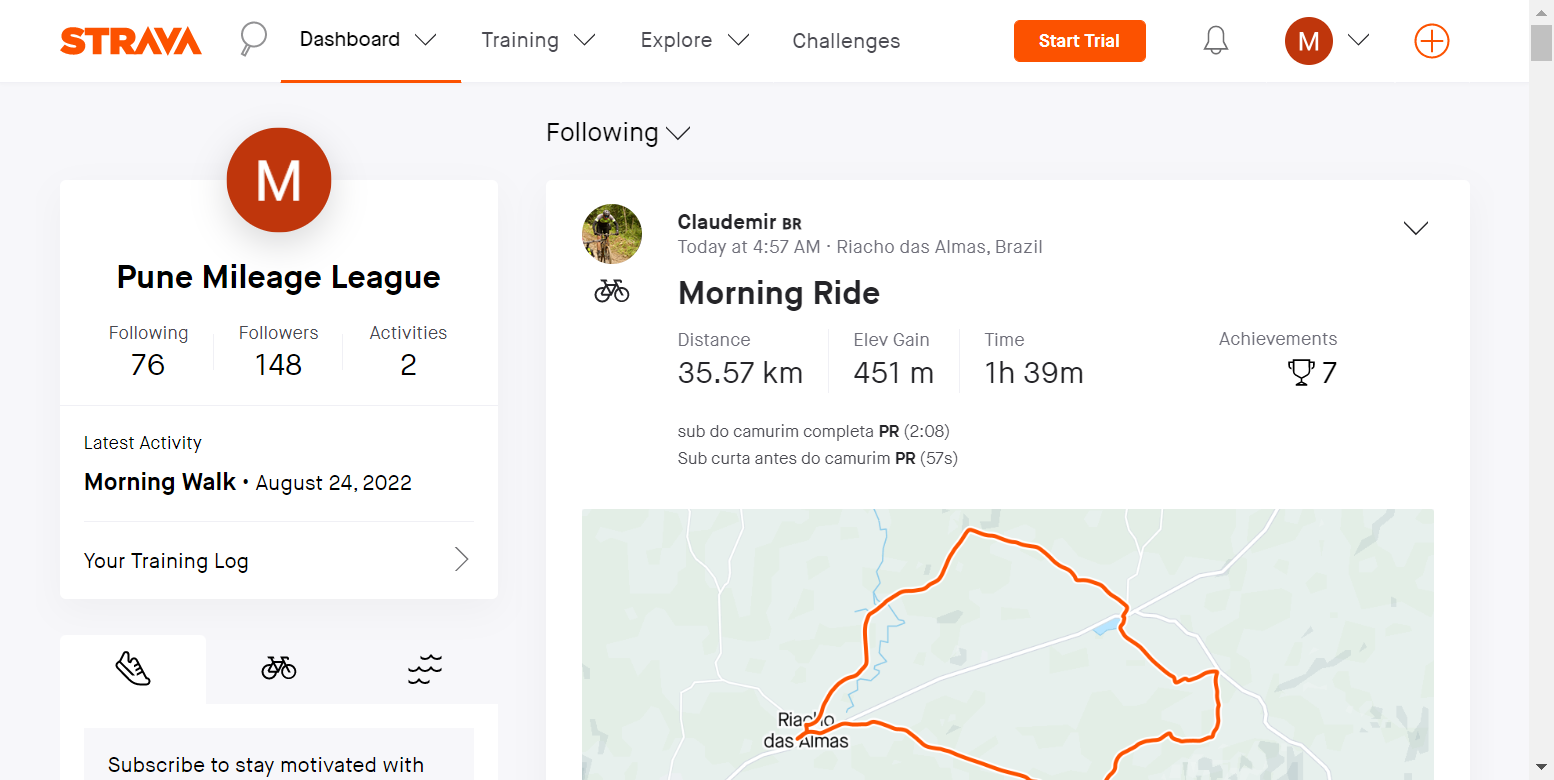

2022-09-22 15:33:38:INFO:Total number of cards on mileage_league_strava/Dashboard | Strava: 39


calling... https://www.strava.com/activities/7847166265


2022-09-22 15:33:45:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.76746349036694 18.644234435632825)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847265717


2022-09-22 15:33:52:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.87863333 18.62118999)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847273374


2022-09-22 15:34:14:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.78503422252834 18.629001835361123)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847016978


2022-09-22 15:34:24:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.78569153137505 18.606091244146228)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847325926


2022-09-22 15:34:35:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.75634741038084 18.64359171129763)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


###  mileage_league_strava https://www.strava.com/clubs/mileageleague Club Likes

2022-09-22 15:34:48:INFO:Total number of cards on https://www.strava.com/clubs/mileageleague 'Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava': 20


###  mileage_league_strava https://www.strava.com/clubs/pcmcrunners Club Likes

2022-09-22 15:35:06:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20


calling... https://www.strava.com/activities/7847991864


2022-09-22 15:35:17:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.77858996391296 18.598660938441753)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847647918


2022-09-22 15:35:39:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.81382287479937 18.636089153587818)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': True},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


###  mileage_league_strava https://www.strava.com/clubs/prettycoolmileagechallenge Club Likes

2022-09-22 15:36:06:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20


calling... https://www.strava.com/activities/7847153366


2022-09-22 15:36:28:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.78386838361621 18.58191104605794)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


###  mileage_league_strava https://www.strava.com/clubs/pcmcbikers Club Likes

2022-09-22 15:36:50:INFO:Total number of cards on https://www.strava.com/clubs/pcmcbikers 'Pimpri-Chinchwad, Maharashtra, India Club | PCMC Tring Tring on Strava': 20


calling... https://www.strava.com/activities/7847413752


2022-09-22 15:37:07:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.77156374976039 18.647531121969223)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847391629


2022-09-22 15:37:16:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.74969284981489 18.55562279932201)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847340179


2022-09-22 15:37:26:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.87294831685722 18.615640243515372)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847336286


2022-09-22 15:37:36:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.9381661452353 18.51504424586892)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


###  mileage_league_strava https://www.strava.com/clubs/punecycling Club Likes

2022-09-22 15:37:57:INFO:Total number of cards on https://www.strava.com/clubs/punecycling 'Pune, Maharashtra, India Club | Strava Pune Cycling on Strava': 20


calling... https://www.strava.com/activities/7847852414


2022-09-22 15:38:23:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.81911638192832 18.618279034271836)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


calling... https://www.strava.com/activities/7847722433


2022-09-22 15:38:31:INFO:Skipping [18.75, 73.65],{'start_xy': 'POINT (73.7608718778938 18.609127337113023)', 'avg_speed': None, 'avg_heartrate': None, 'has_heartrate': False},[18.58, 73.87],Well done! 
You are invited to join mileage challenge at https://pcmcrunners.in/to/challenge for FREE certificates of accomplishments, and leaderboards.
 


###  mileage_league_strava https://www.strava.com/clubs/didyouruntoday Club Likes

2022-09-22 15:38:51:INFO:Total number of cards on https://www.strava.com/clubs/didyouruntoday 'Mumbai, Maharashtra, India Club | Did you run today on Strava': 20


2022-09-22 15:39:29:WARNING:giveKudos: 12 error clicking TimeoutError("timed out after 10 seconds, waiting for true condition on #<SVG: located: False; {'title': re.compile('.*ive kudos'), 'tag_name': 'button', 'index': 12} --> {'data_testid': 'filled_kudos', 'tag_name': 'svg'}>")


TimeoutError: ('Error 423?:', TimeoutError("timed out after 10 seconds, waiting for true condition on #<SVG: located: False; {'title': re.compile('.*ive kudos'), 'tag_name': 'button', 'index': 12} --> {'data_testid': 'filled_kudos', 'tag_name': 'svg'}>"))

In [10]:
for _user,_config in {
                    "avinash":"avinash",
                    "mileage_league_strava":"mileage_league_strava",
                    # "strava_pcmcrunners":"strava_pcmcrunners"
                    }.items():
    display(Markdown(f"### {_user} Feed Likes"))
    strava.login(_user)
    strava.goto('https://www.strava.com/dashboard')
    display(Image(b.screenshot.png()))
    strava.scrolldown(4) 
    _cards=len(b.divs(class_name=re.compile('^Card')))
    logging.info(f"Total number of cards on {_user}/{strava.browser.title}: {_cards}")
    ret=strava.giveKudos()
    #SessionLog :   Date	SessionType	User	Feed	cards	actions
    sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,'feed',_cards,ret['tot_kudos']]])
    
    for club in strava.cfg['strava'][_config]['clubs']:
      display(Markdown(f"###  {_user} {club} Club Likes"))
      strava.goto(f"{club}/recent_activity")
      _cards=len(b.divs(class_name=re.compile('^Card')))
      logging.info(f"Total number of cards on {club} '{strava.browser.title}': {_cards}")
      ret=strava.giveKudos()
      #SessionLog :   Date	SessionType	User	Feed	cards	actions
      sessionGSheet.append_table([[pd.Timestamp.now().isoformat(),"Kudos",_user,club,_cards,ret['tot_kudos']]])
    strava.logout()
logging.info(f"All Groups done")    

# Archive Logs

In [ ]:
MIN_ROWS_TO_ARCHIVE=2000

if os.name=='posix':
    for sh in promoSheet.ws.worksheets():
      print(sh.title,sh.rows,sh.cols,sh.rows*sh.cols,'cells')
    
      if 'StravaPromoLog' in sh.title:
        df=sh.get_as_df()
        
        if len(df) > MIN_ROWS_TO_ARCHIVE:
          df.to_csv(f"{DATA}/{fileName}")

          fileName=f"{sh.title.replace(' ','_')}_{pd.Timestamp.now().isoformat()[:13]}.csv"
          logging.info(f"Saving to {fileName}")

          sh.delete_cols(len(df.columns)+1,
                         number=sh.rows-len(df.columns)-1)
          sh.delete_rows(2, number=len(df))
          logging.info(f'Cleared tab {sh.title}')

# test

In [ ]:
# {x.text[:30]:x.link().href for x in b.divs(data_testid="activity_entry_container")}

In [ ]:
# del strava,Strava
if False:
    %env COUNTER_PROMO_COMMENT 0
    
    importlib.reload(socialmediasite)
    strava=socialmediasite.Strava(b,                                      #authFile=f'{AUTH}/auth.yaml',
                  cfg=cfg,
                  delay=.5)
    df_mc=gsheets.Gsheet(cfg['sheets']['stravasync']['url'],service_account_file=service_account_file
                        ).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')
   
    strava.logGSheet = gsheets.Gsheet(cfg['sheets']['StravaPromoLog']['url'],
                             service_account_file=service_account_file
                             ).getSheetByTitle('StravaPromoLog') 
    strava.promoCommentLog = gsheets.Gsheet(cfg['sheets']['StravaPromoLog']['url'],
                                   service_account_file=service_account_file
                                   ).getSheetByTitle('PromoCommentLog')
    strava.promoCommentedIds=list(strava.promoCommentLog.get_as_df().id.values)
    strava.StravaMembers=df_mc.query('strava=="strava"').id.values
    sessionGSheet = Gsheet(cfg['sheets']['StravaPromoLog']['url'],service_account_file=service_account_file
                          ).getSheetByTitle('SessionLog')
    ##
    for user in ["mileage_league_strava"]:
        strava.login(user)
        for club in strava.cfg['strava'][user]['clubs']:
            display(Markdown(f"###  {user} {club} Club Likes"))
            strava.goto(f"{club}/recent_activity")

            # strava.scrolldown(4)

            for i,kudoTag in enumerate(b.buttons({'data_testid':'kudos_button'})):
                actEl=kudoTag.parent(class_name='Card--feed-entry--eeHS5')
                # print(i,actEl.text[:30].replace('\n','|'))
                if True:
                  # self=strava
                  ath,athUrl,loc,act,actUrl,kudoCount=strava.getPostData(actEl)

                  athId,athIdCat=strava._getAthIdCat(athUrl)
                  print('>',athId,ath,actUrl,loc, 
                        strava.checkPromoComment(athId,athIdCat,athUrl,ath,actUrl,loc))
                    # self.printKudos(i,athIdCat,ath,athUrl,loc,act,actUrl,kudoCount,promoSuccess)

